<a href="https://colab.research.google.com/github/deepeshhada/SA-GAN/blob/master/Evalution%20-%20Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import os
import pathlib

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
from torch import Tensor
from torch.nn import Parameter

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
image_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# Spectral Normalization

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [0]:
# Model Hyperparameters
z_dim = 100

In [0]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()        
        
        self.query_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input):
        B, C, width, height = input.size()
        N = width*height

        query_transpose = self.query_conv(input).view(B, -1, N).permute(0, 2, 1) # B X N X C
        key = self.key_conv(input).view(B, -1, N) # B X C X N
        
        attention_unnormalized = torch.bmm(query_transpose, key) # batch matmul
        attention = self.softmax(attention_unnormalized) # B X N X N
        
        value = self.value_conv(input).view(B, -1, N) # B X C X N

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(B, C, width, height)
        out = self.gamma * out + input # add input feature maps to self attention

        return out, attention

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layer1 = []
        layer2 = []
        layer3 = []
        layer4 = []
        layer5 = []
        # 100 X 1 X 1
        layer1.append(SpectralNorm(nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)))
        layer1.append(nn.BatchNorm2d(512))
        layer1.append(nn.ReLU(inplace=True))
        # 512 X 4 X 4
        layer2.append(SpectralNorm(nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)))
        layer2.append(nn.BatchNorm2d(256))
        layer2.append(nn.ReLU(inplace=True))
        # 256 X 8 X 8
        layer3.append(SpectralNorm(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)))
        layer3.append(nn.BatchNorm2d(128))
        layer3.append(nn.ReLU(inplace=True))
        # 128 X 16 X 16
        layer4.append(SpectralNorm(nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)))
        layer4.append(nn.BatchNorm2d(64))
        layer4.append(nn.ReLU(inplace=True))
        # 64 X 32 X 32
        layer5.append(nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False))
        layer5.append(nn.Tanh())
        # 3 x 64 X 64

        self.layer1 = nn.Sequential(*layer1)
        self.layer2 = nn.Sequential(*layer2)
        self.layer3 = nn.Sequential(*layer3)
        self.attention1 = SelfAttention(in_channels=128)
        self.layer4 = nn.Sequential(*layer4)
        self.attention2 = SelfAttention(in_channels=64)
        self.layer5 = nn.Sequential(*layer5)


    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1) # batch=8 X z_dim=100 X 1 X 1
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, map1 = self.attention1(out)
        out = self.layer4(out)
        out, map2 = self.attention2(out)
        out = self.layer5(out)

        return out

G = Generator().to(device)

In [8]:
batch_size = 64
test_set = torchvision.datasets.CIFAR10(
    root='./drive/My Drive/datasets/data',
    train=False,
    download=True,
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)
testloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False
)

Files already downloaded and verified


In [0]:
from torchvision.utils import save_image
base_path = "./drive/My Drive/datasets/"
real_path = base_path + "real images/"
fake_path = base_path + "fake images/"

def generate_fake_images():
    model_path = "./drive/My Drive/saved models/sagan"
    torch.manual_seed(0)
    G.load_state_dict(torch.load(model_path + " - generator"))

    for i in range(0, 100):
        noise = torch.randn(100, z_dim, 1, 1, device=device)
        with torch.no_grad():
            fake = G(noise).detach().cpu()
        for j in range(0, 100):
            save_image(fake[j], fake_path + 'img' + str(i*100 + j) + '.png')


def real_images():
    for i, data in enumerate(testloader, 0):
        real_inputs = data[0].detach().cpu()
        save_image(real_inputs, real_path + 'img' + str(i) + '.png')
        if i % 1000 == 0:
            print(i)

# generate_fake_images()

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`

    Skips default weight inititialization if supported by torchvision version.
    See https://github.com/mseitzer/pytorch-fid/issues/28.
    """
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    if version >= (0, 6):
        kwargs['init_weights'] = False

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [0]:
try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    pred_arr = np.empty((len(files), dims))

    for i in tqdm(range(0, len(files), batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

100%|██████████| 105/105 [43:58<00:00, 25.13s/it]


FID:  72.08318700401821


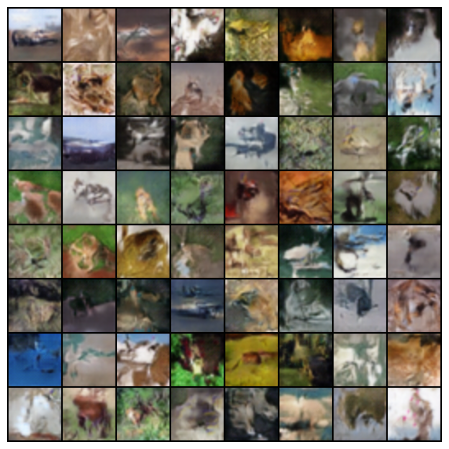

In [12]:
model_path = "./drive/My Drive/saved models/sagan"
torch.manual_seed(0)
G.load_state_dict(torch.load(model_path + " - generator"))

noise = torch.randn(64, z_dim, 1, 1).to(device)
with torch.no_grad():
    fake = G(noise).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)

figs = plt.figure(figsize=(8, 8))
plt.axis("off")
disp = [plt.imshow(np.transpose(img, (1,2,0)), animated=False)]

paths = [real_path, fake_path]
batch_size = 64
fid_value = calculate_fid_given_paths(paths, batch_size, True, 2048)
print('FID: ', fid_value)